In [27]:
from collections import Counter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import umap.plot
import diptest
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy.fft import dct
from scipy.spatial.distance import pdist, squareform
from tslearn.metrics import cdist_dtw

import sys
sys.path.append('../')
from src.dataset import Dataset
from src.condition import Condition
from src.representations import contour_array
from src.preprocess.synthesize import MarkovSynthesizer, subsample_clustered_contours
from helpers import cm2inch, title
from matplotlib.colors import LogNorm
matplotlib.style.use('styles.mplstyle')

from src.visualize import get_pval_cmap, format_pval

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [7]:
def show_distance_distribution(
        distances, alpha=0.05, ax=None, 
        uni_fmt='Unimodal ($p={}$)', 
        multi_fmt='Multimodal ($p={}$)', text_kws={}
    ):
    _text_kws = dict(xy=(1, 1), xycoords='axes fraction', ha='right', va='top')
    _text_kws.update(text_kws)

    if ax is None: ax = plt.gca()
    cmap = get_pval_cmap(min_gray=0.15, vmin=1e-5)
    norm = LogNorm(vmin=1e-5, vmax=1)
    dip, pval = diptest.diptest(distances)
    sns.histplot(distances, lw=0, color=cmap(norm(pval + 1e-8)), ax=ax)
    
    fmt = multi_fmt if pval < alpha else uni_fmt
    result = fmt.format(format_pval(pval))
    ax.annotate(result, **_text_kws)

    ax.set_ylabel('')
    ax.set_xlabel('distance')
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

#show_distance_distribution(pdist(X))

In [8]:
def show_embeddings(X, labels=None, ax=None, name='', s=6, c=None, **kwargs):
    if ax is None: ax = plt.gca()
    if labels is not None:
        colors = [f'C{c}' for c in labels]
    else:
        colors = c
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=s,  **kwargs)
    ax.annotate(name, 
        xy=(0, 1), xycoords='axes fraction', 
        xytext=(5, -5), textcoords='offset points',
        ha='left', va='top', fontsize=11, color='0.5')
    ax.set_yticks([])
    ax.set_xticks([])

In [9]:
def show_umap_dist_test(X, labels=None, **umap_kws):
    dim = min(5, X.shape[1])
    _umap_kws = dict(min_dist=0, n_neighbors=50, random_state=1, n_components=dim)
    _umap_kws.update(umap_kws)
    fig, axs = plt.subplots(2, 2, gridspec_kw=dict(height_ratios=[3,1]), figsize=(8, 5), tight_layout=True)

    title('A. Dist-dip test', ax=axs[0, 0])
    X_pca = PCA(n_components=2).fit_transform(X)
    show_embeddings(X_pca, labels, ax=axs[0, 0], name='PCA')
    show_distance_distribution(pdist(X), ax=axs[1, 0])
    axs[0,0].set_ylabel('Visualization', fontweight='bold')

    title('B. UMAP-dip test', ax=axs[0, 1])
    axs[1, 0].set_ylabel('Distance\ndistribution', fontweight='bold')
    X_umap = umap.UMAP().fit_transform(X)
    show_embeddings(X_umap, labels, ax=axs[0, 1], name='2d UMAP')
    if dim == 2:
        dists = pdist(X_umap)
    else:
        dists = pdist(umap.UMAP(**_umap_kws).fit_transform(X))
    show_distance_distribution(dists, ax=axs[1, 1])

# show_umap_dist_test(X, y)

In [10]:
from src.visualize import show_inset_plot, grid_around_points, average_inv_contours

In [11]:
unclustered = Condition(dataset='markov', representation='pitch_centered', metric='eucl', limit=3000, dimensionality=50, length=None)
clustered = Condition(dataset='clustered', representation='pitch_centered', metric='eucl', limit=3000, dimensionality=50, length=None)
labels = clustered.df['label']

In [160]:
mapper = umap.UMAP(random_state=0).fit(unclustered.contours())
X_unif = mapper.embedding_
X_clust = mapper.transform(clustered.contours())

In [161]:
centers = [clustered.contours()[labels == c].mean(axis=0) for c in range(5)]
centers = np.array(centers)
X_center = mapper.transform(centers)

In [162]:
# Average inverse contours
gridpoints, inside = grid_around_points(X_unif, subdiv=8, margin=0.03)
inv_contours = average_inv_contours(mapper.inverse_transform, gridpoints, num_samples=25, eps=0.3)

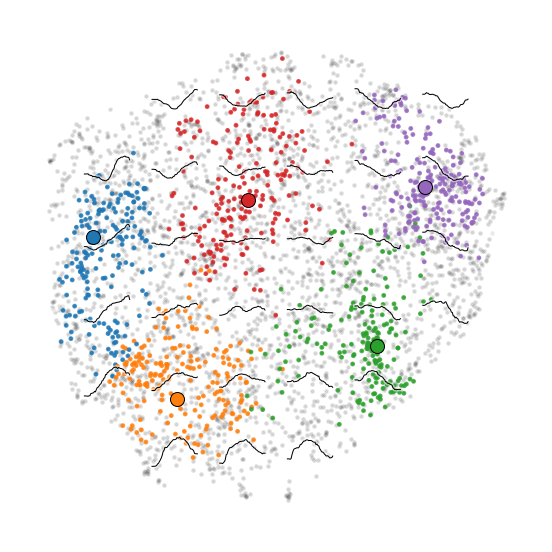

In [163]:
fig = plt.figure(figsize=cm2inch(10, 10), tight_layout=True)

inset_axes = show_inset_plot(X_unif, gridpoints, inside, inv_contours, 
    marker=False, inset_height=.5,
    scatter_kws=dict(color='k', s=2, alpha=.1),
    outside_plot_kws=dict(alpha=0),
    inset_plot_kws=dict(lw=0.5),
    inset_bg_plot_kws=dict(alpha=.5)
    )
    
for ax in inset_axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

subset =  np.random.choice(np.arange(X_clust.shape[0]), size=1000, replace=False)
show_embeddings(X_clust[subset, :], clustered.df['label'][subset], s=2, alpha=.8)

for i, (x, y) in enumerate(X_center):
    plt.plot(x, y, 'o', ms=7, markeredgecolor='k', markeredgewidth=.5)

# plt.savefig('../figures/fig-synthetic/umap-raw.pdf')

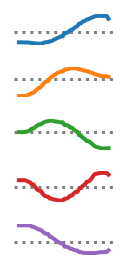

In [66]:
labels = clustered.df['label']
n_clusters = len(labels.unique())
fig, axs = plt.subplots(n_clusters, figsize=cm2inch(2.5, 5), tight_layout=True)
for i in range(n_clusters):
    X = clustered.contours()[labels == i]
    axs[i].axhline(0, c='0.5', ls=':')
    axs[i].plot(X.mean(axis=0), c=f'C{i}', lw=2)
    axs[i].axis('off')

# plt.savefig('../figures/fig-synthetic/cluster-centers-raw.pdf')

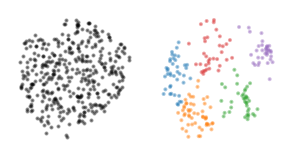

In [147]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(6, 3))
show_embeddings(X_unif[:400, :], color='k', s=1, alpha=.4, ax=ax0)
subset =  np.random.choice(np.arange(X_clust.shape[0]), size=200, replace=False)
show_embeddings(X_clust[subset, :], clustered.df['label'][subset], s=1, alpha=.4, ax=ax1)
ax0.axis('off')
ax1.axis('off')
plt.savefig('../figures/fig-synthetic/two-embeddings.pdf')

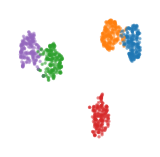

In [158]:
np.random.seed(0)
subset = np.random.choice(np.arange(X_clust.shape[0]), size=1000, replace=False)
fig, ax0 = plt.subplots(1, figsize=cm2inch(3, 3))
show_embeddings(clustered.umap_2d_embeddings()[subset], clustered.df['label'][subset], s=.5, alpha=.5, ax=ax0)
ax0.axis('off')
plt.savefig('../figures/fig-synthetic/clustered-embeddings.pdf')

### Alternative projections

In [18]:
from sklearn.decomposition import PCA
from scipy.fft import dct

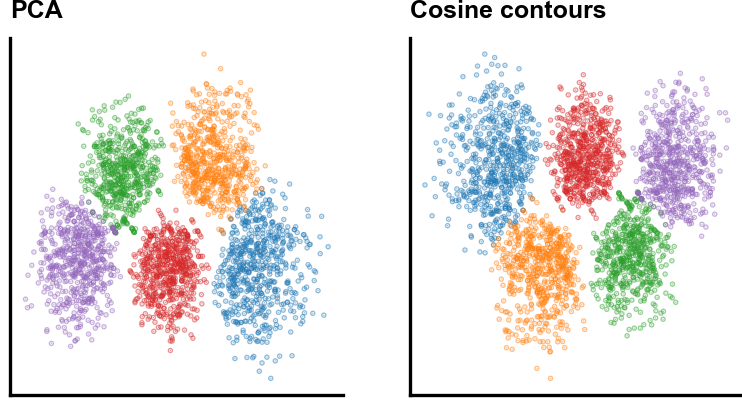

In [32]:
fig, axs = plt.subplots(1, 2, figsize=cm2inch(8, 4))

plt.sca(axs[0])
title('PCA')
X_pca = PCA(n_components=2).fit_transform(clustered.contours())
show_embeddings(X_pca, clustered.df['label'], s=.1, alpha=.5)

plt.sca(axs[1])
title('Cosine contours')
X_cos = dct(clustered.contours())[:, 1:3]
show_embeddings(X_cos, clustered.df['label'], s=.1, alpha=.5)